In [8]:
from keras import models
from keras import layers
from keras import regularizers
from keras.datasets import boston_housing

Load data

In [9]:
(train_data, train_targets), (test_data, test_targets) = \
    boston_housing.load_data()

Prepare data

We should normoalize the data from different unit or category data

In this we using Z-score（Standardization), which mean = 0 and standerdiviation = 1

In [10]:
mean = train_data.mean(axis=0) # align the row
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

Construct the network

In [11]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu',
                       input_shape = (train_data.shape[1],)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer='rmsprop', loss='mse',
              metrics = ['mae'])

In [12]:
L1_model = models.Sequential()
L1_model.add(layers.Dense(64, activation='relu',
                       input_shape = (train_data.shape[1],),
                       kernel_regularizer = regularizers.L1(0.001)))
L1_model.add(layers.Dense(64, activation='relu',
                          kernel_regularizer = regularizers.L1(0.001)))
L1_model.add(layers.Dense(1))

L1_model.compile(optimizer='rmsprop', loss='mse',
              metrics = ['mae'])

In [13]:
L2_model = models.Sequential()
L2_model.add(layers.Dense(64, activation='relu',
                       input_shape = (train_data.shape[1],),
                       kernel_regularizer = regularizers.L2(0.001)))
L2_model.add(layers.Dense(64, activation='relu',
                          kernel_regularizer = regularizers.L2(0.001)))
L2_model.add(layers.Dense(1))

L2_model.compile(optimizer='rmsprop', loss='mse',
              metrics = ['mae'])

In [14]:
L12_model = models.Sequential()
L12_model.add(layers.Dense(64, activation='relu',
                       input_shape = (train_data.shape[1],),
                       kernel_regularizer = regularizers.L1L2(l1=0.001, l2=0.001)))
L12_model.add(layers.Dense(64, activation='relu',
                          kernel_regularizer = regularizers.L1L2(l1=0.001, l2=0.001)))
L12_model.add(layers.Dense(1))

L12_model.compile(optimizer='rmsprop', loss='mse',
              metrics = ['mae'])

K-fold cross validation

In [15]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 80
model_list = [model, L1_model, L2_model, L12_model]
mae_dic = {model : [], L1_model : [], L2_model : [], L12_model : []}
av_mae_dic = {model : [], L1_model : [], L2_model : [], L12_model : []}

for m in model_list:
    for i in range(k):
        print(f'processing fold {i}')
        val_data = train_data[i * num_val_samples : (i + 1) * num_val_samples]
        val_targets = train_targets[i * num_val_samples : (i + 1) * num_val_samples]
        partial_train_data = np.concatenate([train_data[:i * num_val_samples],
                                            train_data[(i + 1) * num_val_samples:]],
                                            axis=0)
        partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],
                                            train_targets[(i + 1) * num_val_samples:]],
                                            axis=0)
        history = model.fit(partial_train_data, partial_train_targets,
                            validation_data=(val_data, val_targets),
                            epochs=num_epochs, batch_size=16, verbose=0)
        val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
        # print(history.history)
        mae_history = history.history['val_mae']
        mae_dic[m].append(mae_history)

for m in model_list:
    av_mae_dic[m] = [np.mean([x[i] for x in mae_dic[m]]) for i in range(num_epochs)]

processing fold 0
processing fold 1
processing fold 2
processing fold 3
processing fold 0
processing fold 1
processing fold 2
processing fold 3
processing fold 0
processing fold 1
processing fold 2
processing fold 3
processing fold 0
processing fold 1
processing fold 2
processing fold 3


Plot validation score

In [16]:
def smooth_curve(points, factor = 0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point *(1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Remove the first 10 pieces of data
smooth_mae_dic = {model : [], L1_model : [], L2_model : [], L12_model : []}
for m in model_list:
    smooth_mae_dic[m] = smooth_curve(av_mae_dic[m][10:])

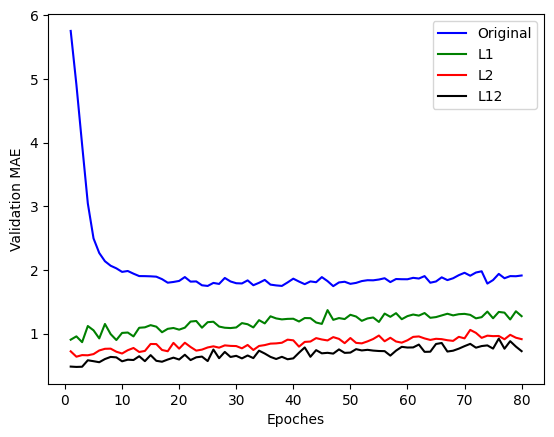

In [22]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(av_mae_dic[model]) + 1), av_mae_dic[model], 'b', label = 'Original')
plt.plot(range(1, len(av_mae_dic[L1_model]) + 1), av_mae_dic[L1_model], 'g', label = 'L1')
plt.plot(range(1, len(av_mae_dic[L2_model]) + 1), av_mae_dic[L2_model], 'r', label = 'L2')
plt.plot(range(1, len(av_mae_dic[L12_model]) + 1), av_mae_dic[L12_model], 'k', label = 'L12')

plt.xlabel('Epoches')
plt.ylabel('Validation MAE')
plt.legend()
plt.show()

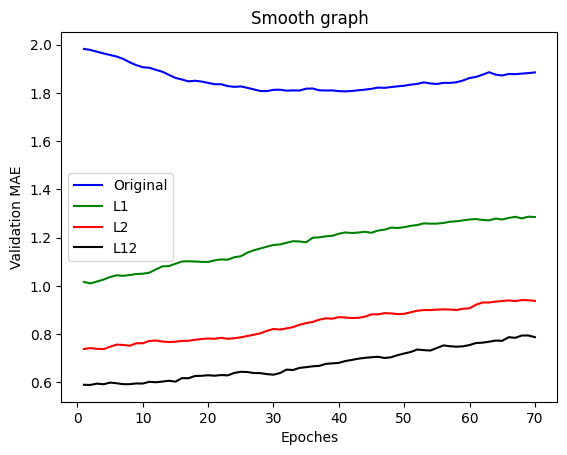

In [23]:
plt.plot(range(1, len(smooth_mae_dic[model]) + 1), smooth_mae_dic[model], 'b', label = 'Original')
plt.plot(range(1, len(smooth_mae_dic[L1_model]) + 1), smooth_mae_dic[L1_model], 'g', label = 'L1')
plt.plot(range(1, len(smooth_mae_dic[L2_model]) + 1), smooth_mae_dic[L2_model], 'r', label = 'L2')
plt.plot(range(1, len(smooth_mae_dic[L12_model]) + 1), smooth_mae_dic[L12_model], 'k', label = 'L12')

plt.title('Smooth graph')
plt.xlabel('Epoches')
plt.ylabel('Validation MAE')
plt.legend()
plt.show()

In [19]:
test_score, test_mae_score = model.evaluate(test_data, test_targets)
print('test_score = ', test_score)
print('test_mae_score = ', test_mae_score)

4/4 [==============================] - 0s 3ms/step - loss: 12.3222 - mae: 2.3950
test_score =  12.322196960449219
test_mae_score =  2.3949625492095947
